In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dbr=pd.read_excel("cohorte.xlsx")
dbr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8637 entries, 0 to 8636
Data columns (total 13 columns):
nconst           8637 non-null object
ordering         8637 non-null float64
startYear        8637 non-null float64
birthYear        8637 non-null int64
averageRating    8412 non-null float64
numVotes         8412 non-null float64
Num5Y            8637 non-null int64
retournera       8637 non-null bool
tconst           8637 non-null int64
SCate            8637 non-null object
SGenr            8637 non-null object
SReg             8637 non-null object
SProf            8637 non-null object
dtypes: bool(1), float64(4), int64(3), object(5)
memory usage: 818.2+ KB


In [3]:
#les Nan correspondent à des films sans rating. Remplisisons à tout hasard par des zéros (on essaiera aussi en les enlevant)
dbr=dbr.fillna(0)

In [4]:
dbr.SReg.value_counts()[0:10]

US    1386
DE     528
IN     484
BR     456
JP     444
CA     367
AR     329
FR     309
RU     307
BG     238
Name: SReg, dtype: int64

# on se restreint aux USA

In [5]:
dbr=dbr[dbr.SReg=='US']

In [6]:
#séparons la variable à expliquer des variables explicatives
y=dbr['retournera']
X=dbr.drop('retournera',axis=1)

In [7]:
X['SCate'].unique()

array(['actor', 'actress'], dtype=object)

In [8]:
#supprimons le nom, ici sans apport d'information
X=X.drop('nconst',axis=1)

In [9]:
#numérisons le genre
X=X.join(pd.get_dummies(X['SCate']))
X=X.drop('actor',axis=1)

In [10]:
#pour l'instant droppons les autres variables objets trop difficile à séparer
X=X.drop('SReg',axis=1)
X=X.drop('SProf',axis=1)
X=X.drop('SGenr',axis=1)
X=X.drop('SCate',axis=1)

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1386 entries, 28 to 8628
Data columns (total 8 columns):
ordering         1386 non-null float64
startYear        1386 non-null float64
birthYear        1386 non-null int64
averageRating    1386 non-null float64
numVotes         1386 non-null float64
Num5Y            1386 non-null int64
tconst           1386 non-null int64
actress          1386 non-null uint8
dtypes: float64(4), int64(3), uint8(1)
memory usage: 128.0 KB


In [12]:
X.actress.describe()

count    1386.000000
mean        0.339827
std         0.473821
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: actress, dtype: float64

In [13]:
#séparons en training et test (pas indispensable puisqu'on veut juste décrire l'observé,mais c'est mieux
# si le sujet intéresse on ajoutera un test out of time)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [15]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {'max_depth': range(1,10)}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring= 'roc_auc', cv=5,return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
print("Test set score: {:.3f}".format(grid_search.score(X_test, y_test)))

Best parameters: {'max_depth': 3}
Best cross-validation score: 0.886
Test set score: 0.871


In [16]:
### en fittant avec ces paramètres sur tout l'échantillon d'apprentissage : 
k=3
tree = DecisionTreeClassifier(max_depth=k)
tree.fit(X_train,y_train)
R2_appr=tree.score(X_train,y_train)
R2_test=tree.score(X_test,y_test)
y_pred=tree.predict(X_test)
roc_test=roc_auc_score(y_test, y_pred)
print('pour une profondeur de',k)
print("la précision sur l'échantillon d'apprentissage est de {:.3f}".format(R2_appr))
print("et la précision sur le vrai échantillon de test est de {:.3f}".format(R2_test))
print("et le roc_auc_score en test est de {:.3f}".format(roc_test))

pour une profondeur de 3
la précision sur l'échantillon d'apprentissage est de 0.840
et la précision sur le vrai échantillon de test est de 0.787
et le roc_auc_score en test est de 0.781


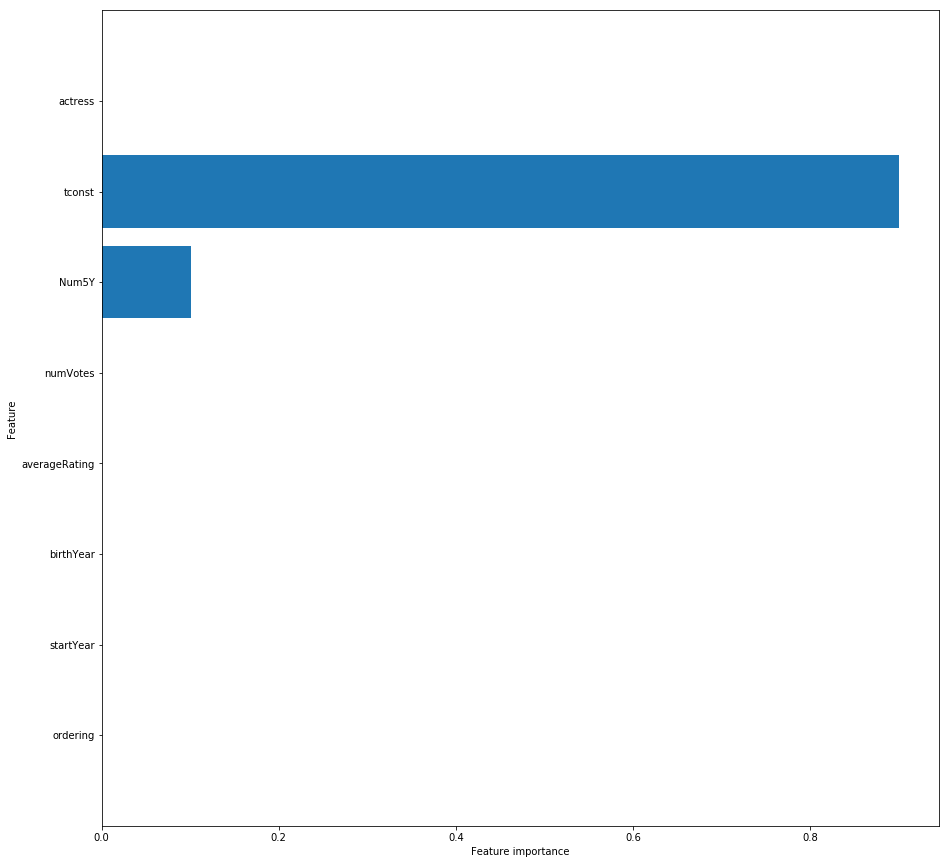

In [17]:
#examinons l'importance respective des variables explicatives

# adapted from Muller & Guido 
# https://github.com/amueller/introduction_to_ml_with_python/blob/master/02-supervised-learning.ipynb

def plot_feature_importances(model, Frame):
    plt.clf()
    n_features=len(Frame.columns)
    plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), Frame.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)


plot_feature_importances(tree,X_train)
plt.show()  

In [18]:
#essayons sans tconst, variable suspecte (ai-je bien enlevé les films suivants ?)
X1_train=X_train.drop('tconst',axis=1)
X1_test=X_test.drop('tconst',axis=1)

In [19]:
param_grid = {'max_depth': range(1,10)}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring= 'roc_auc', cv=5,return_train_score=True)
grid_search.fit(X1_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
print("Test set score: {:.3f}".format(grid_search.score(X1_test, y_test)))

Best parameters: {'max_depth': 4}
Best cross-validation score: 0.680
Test set score: 0.677


In [20]:
### en fittant avec ces paramètres sur tout l'échantillon d'apprentissage : 
k=4
tree1 = DecisionTreeClassifier(max_depth=k)
tree1.fit(X1_train,y_train)
R2_appr=tree1.score(X1_train,y_train)
R2_test=tree1.score(X1_test,y_test)
y_pred=tree1.predict(X1_test)
roc_test=roc_auc_score(y_test, y_pred)
print('pour une profondeur de',k)
print("la précision sur l'échantillon d'apprentissage est de {:.3f}".format(R2_appr))
print("et la précision sur le vrai échantillon de test est de {:.3f}".format(R2_test))
print("et le roc_auc_score en test est de {:.3f}".format(roc_test))

pour une profondeur de 4
la précision sur l'échantillon d'apprentissage est de 0.692
et la précision sur le vrai échantillon de test est de 0.643
et le roc_auc_score en test est de 0.656


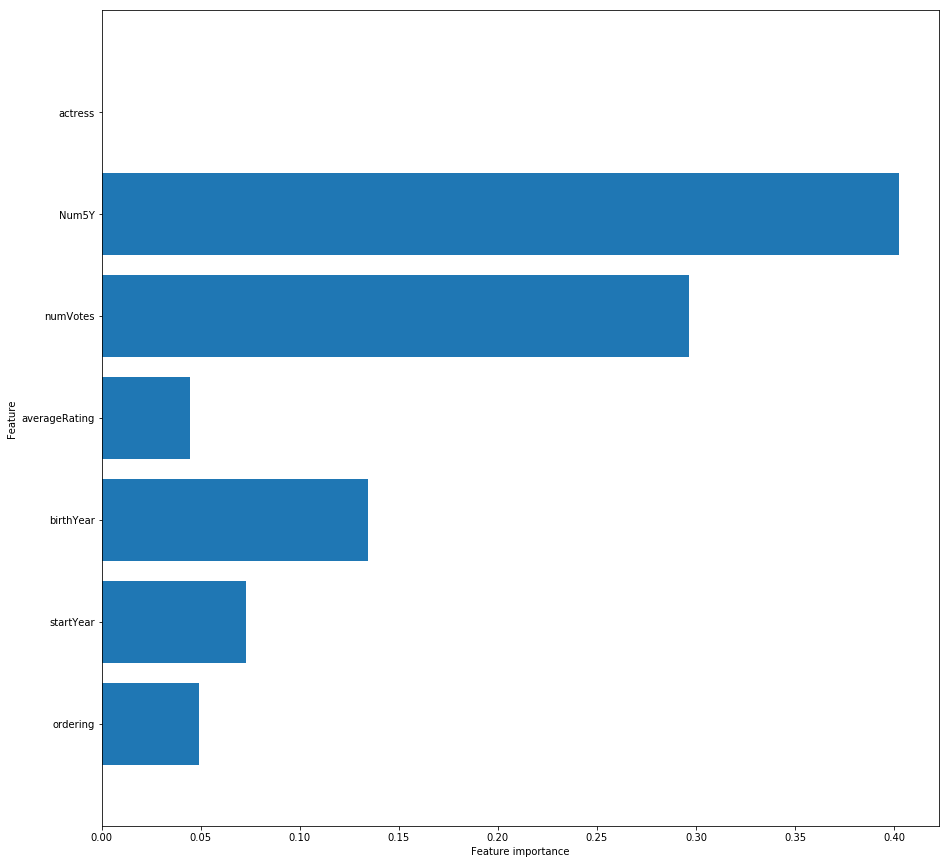

In [21]:
#examinons l'importance respective des variables explicatives
plot_feature_importances(tree1,X1_train)
plt.show()  